# Structured Grader Evaluation

This notebook evaluates multiple LLMs as graders using the structured grader prompt.
It compares AI outputs against ground truth answers with expected scores.

In [12]:
import os
import json
import pandas as pd
from typing import List, Dict
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv


## Define the Structured Grader Schema and Prompt

Using the prompt from `policy_bot/ai/rubric.py`

In [14]:
# Boolean flag to control whether to include examples in the prompt
INCLUDE_EXAMPLES = True

# Create a prompt template for scoring AI responses against ground truth
if INCLUDE_EXAMPLES:
    score_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            (
                "You are an expert evaluator. "
                "Given an AI's response to a question and the ground truth answer, "
                "score the AI's response on a scale from 0 to 3 based on correctness:\n"
                "0 = Completely does not match the ground truth or is irrelevant\n"
                "1 = Partially matches the ground truth, but with major errors or omissions\n"
                "2 = Mostly matches the ground truth, but with at most a single minor error or at most a single missing detail\n"
                "3 = Completely matches the ground truth exactly\n\n"
                "Here are examples of each score with reasoning:\n\n"
                "EXAMPLE - Score 3 (Perfect Match):\n"
                "Question: What is the square root of 144?\n"
                "Ground Truth: 12\n"
                "AI Response: The square root of 144 is 12.\n"
                "Reasoning: The AI response correctly identifies the answer as 12, which matches the ground truth exactly. The additional context ('The square root of 144 is') does not detract from the correctness of the answer.\n"
                "Score: 3\n\n"
                "EXAMPLE - Score 2 (Minor Error):\n"
                "Question: Name the four seasons in order.\n"
                "Ground Truth: Spring, Summer, Fall, Winter\n"
                "AI Response: Spring, Summer, Autumn, Winter\n"
                "Reasoning: The AI response correctly identifies all four seasons in the correct order. However, it uses 'Autumn' instead of 'Fall'. Since 'Autumn' and 'Fall' are synonymous terms for the same season, this is a minor naming variation rather than a factual error. All other elements match the ground truth exactly.\n"
                "Score: 2\n\n"
                "EXAMPLE - Score 1 (Major Errors/Omissions):\n"
                "Question: List the planets in our solar system.\n"
                "Ground Truth: Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, Neptune\n"
                "AI Response: Earth, Mars, Jupiter, Saturn\n"
                "Reasoning: The AI response correctly identifies 4 planets (Earth, Mars, Jupiter, Saturn), which are all included in the ground truth. However, it is missing 4 other planets (Mercury, Venus, Uranus, Neptune), representing a 50% omission rate. This is a major omission as half of the required information is missing. The planets provided are correct but incomplete.\n"
                "Score: 1\n\n"
                "EXAMPLE - Score 0 (Completely Wrong):\n"
                "Question: What is the chemical formula for water?\n"
                "Ground Truth: H2O\n"
                "AI Response: CO2\n"
                "Reasoning: The AI response provides CO2 (carbon dioxide) when the ground truth is H2O (water). These are completely different chemical compounds with different properties and compositions. The response does not match the ground truth in any way and provides factually incorrect information.\n"
                "Score: 0"
            )
        ),
        (
            "human",
            (
                "Question: {question}\n"
                "Ground Truth: {ground_truth}\n\n"
                "AI Response: {ai_response}\n"
                "The goal is to match the AI response to the ground truth. Your score should be based on how well the AI response matches the ground truth, nothing else. Score the AI response from 0 to 3."
            )
        )
    ])
else:
    score_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            (
                "You are an expert evaluator. "
                "Given an AI's response to a question and the ground truth answer, "
                "score the AI's response on a scale from 0 to 3 based on correctness:\n"
                "0 = Completely does not match the ground truth or is irrelevant\n"
                "1 = Partially matches the ground truth, but with major errors or omissions\n"
                "2 = Mostly matches the ground truth, but with at most a single minor error or at most a single missing detail\n"
                "3 = Completely matches the ground truth exactly"
            )
        ),
        (
            "human",
            (
                "Question: {question}\n"
                "Ground Truth: {ground_truth}\n\n"
                "AI Response: {ai_response}\n"
                "The goal is to match the AI response to the ground truth. Your score should be based on how well the AI response matches the ground truth, nothing else. Score the AI response from 0 to 3."
            )
        )
    ])

## Create Test Dataset

Define test cases with AI outputs, ground truth, and expected scores

In [15]:
# Test dataset: pairs of AI outputs, ground truth, and expected scores
test_dataset = [
    {
        "question": "For the driver who set the fastest lap speed, what is his nationality?",
        "ai_response": "This person is from Spain",
        "ground_truth": "Spanish",
        "expected_score": 3 # Tests if grader handles nationality correctly
    },
    {
        "question": "Which constructor has the highest point?",
        "ai_response": "The constructor with the highest points is Mercedes, with a total of 765 points.",
        "ground_truth": "[('Mercedes',)]",
        "expected_score": 3 # Tests if grader handles constructor name correctly
    },
    {
        "question": "For all patients who are older than 55 years old, what is the percentage of female who has abnormal prothrombin time (PT)?",
        "ai_response": "For patients older than 55 years old who are female (SEX = 'F'), there are 8,744 total females and 153 of them have an abnormal prothrombin time (PT > 13.5).\n\nTo calculate the percentage of females with abnormal PT: (153 / 8744) * 100 = 1.75%\n\nSo, approximately 1.75% of females older than 55 years have an abnormal prothrombin time (PT).",
        "ground_truth": "[(1.2037369744879627,)]",
        "expected_score": 1 # Tests if grader handles percentage calculation correctly
    },
    {
        "question": "What are the three primary colors and how do they combine to form other colors?",
        "ai_response": "The three primary colors are red, blue, and yellow. They combine to form other colors through color mixing.",
        "ground_truth": "The three primary colors are red, blue, and yellow. For example, red and blue make purple.",
        "expected_score": 2  # Tests if grader handles color mixing correctly
    },
        {
        "question": "What is the total revenue for the year 2023 across all regions?",
        "ai_response": "The total revenue for 2023 was $4.2M, with North America contributing $2.1M, Europe $1.5M, and Asia $0.6M.",
        "ground_truth": "4200000",
        "expected_score": 3  # Tests if grader handles $4.2M vs 4200000 correctly
    },
    {
        "question": "Which country won the most gold medals in the 2024 Olympics?",
        "ai_response": "The United States won the most gold medals with 40, followed by China with 40, but the US had more total medals.",
        "ground_truth": "USA and China (tie at 40)",
        "expected_score": 3  # Tests handling of ties and extra context
    },
    {
        "question": "What is the treatment for a common cold?",
        "ai_response": "Antibiotics are the primary treatment for a common cold to kill the virus.",
        "ground_truth": "Rest, fluids, and over-the-counter medications. Antibiotics do not work on viruses.",
        "expected_score": 0  # Tests if grader catches a dangerous factual/conceptual error
    },
    {
        "question": "How many employees does the company have as of Q4 2023?",
        "ai_response": "As of the end of 2023, the company headcount was approximately 12,500.",
        "ground_truth": "12482",
        "expected_score": 2  # Tests if "approximately" is acceptable for a specific number
    },
    {
        "question": "Calculate the derivative of f(x) = x^2 + 3x.",
        "ai_response": "f'(x) = 2x + 3x",
        "ground_truth": "2x + 3",
        "expected_score": 1  # Tests if grader catches a subtle math error (3x instead of 3)
    },
    {
        "question": "What is the boiling point of water at sea level?",
        "ai_response": "Water boils at 100 degrees.",
        "ground_truth": "100 degrees Celsius or 212 degrees Fahrenheit",
        "expected_score": 2  # Tests if missing units (Celsius) is penalized as a minor error
    },
    {
        "question": "Who wrote 'To Kill a Mockingbird'?",
        "ai_response": "The novel was written by Harper Lee in 1960.",
        "ground_truth": "Harper Lee",
        "expected_score": 3  # Tests if extra correct context (year) is ignored/rewarded
    },
    {
        "question": "For all patients who are older than 55 years old, what is the percentage of female who has abnormal prothrombin time (PT)?",
        "ai_response": "The percentage is 1.75%.",
        "ground_truth": "[(1.2037369744879627,)]",
        "expected_score": 0  # Tests if a completely wrong number is penalized despite correct format
    }
    
    
]

print(f"Created test dataset with {len(test_dataset)} test cases")

Created test dataset with 12 test cases


## Define Grader Function

Function to score an AI response using a specified LLM model

In [16]:
# Define the Pydantic model for structured output
INCLUDE_COT = True  
if INCLUDE_COT:
    class ScoreResponse(BaseModel):
        reasoning: str = Field(
            description="The reasoning process of what score you should pick. "
            "This should be detailed. Outline the points in the ground truth that "
            "the AI response correctly answered and incorrectly missed."
        )
        score: int = Field(
            description="An integer between 0 and 3 representing the correctness "
            "of the AI response compared to the ground truth"
        )
else:
    class ScoreResponse(BaseModel):
        score: int = Field(
            description="An integer between 0 and 3 representing the correctness "
            "of the AI response compared to the ground truth"
        )


def get_structured_scorer(model_name: str = "meta-llama/llama-4-scout", temperature: float = 0):
    """
    Returns a function that scores an AI response against ground truth using a specified model.
    """
    llm = ChatOpenAI(
        model=model_name,
        temperature=temperature,
        base_url="https://openrouter.ai/api/v1",
        api_key=os.getenv("OPENROUTER_API_KEY"),
        extra_body={"provider": {"order": ['groq']}}
    )
    structured_llm = llm.with_structured_output(ScoreResponse)

    def score_ai_response(question: str, ai_response: str, ground_truth: str):
        prompt = score_prompt.format(
            question=question,
            ai_response=ai_response,
            ground_truth=ground_truth
        )
        return structured_llm.invoke(prompt)

    return score_ai_response

## Test Multiple LLMs

Evaluate multiple LLM models as graders

In [17]:
# Define models to test
models_to_test = [
    "meta-llama/llama-4-scout",
    "openai/gpt-4o-mini",
    "openai/gpt-5.2",
    "anthropic/claude-opus-4.5",
    "anthropic/claude-sonnet-4.5",
    "moonshotai/kimi-k2-0905",
    "upstage/solar-pro-3:free",
    "google/gemini-3-flash-preview",
    "google/gemini-2.5-flash-preview-09-2025"
]

print(f"Testing {len(models_to_test)} models:")
for model in models_to_test:
    print(f"  - {model}")

Testing 9 models:
  - meta-llama/llama-4-scout
  - openai/gpt-4o-mini
  - openai/gpt-5.2
  - anthropic/claude-opus-4.5
  - anthropic/claude-sonnet-4.5
  - moonshotai/kimi-k2-0905
  - upstage/solar-pro-3:free
  - google/gemini-3-flash-preview
  - google/gemini-2.5-flash-preview-09-2025


In [18]:
# Run evaluation for each model
results = []

for model_name in models_to_test:
    print(f"\n{'='*60}")
    print(f"Testing model: {model_name}")
    print(f"{'='*60}")
    
    try:
        scorer = get_structured_scorer(model_name=model_name, temperature=0)
        
        for i, test_case in enumerate(test_dataset, 1):
            print(f"\nTest case {i}/{len(test_dataset)}:")
            print(f"  Question: {test_case['question']}")
            
            try:
                score_result = scorer(
                    question=test_case['question'],
                    ai_response=test_case['ai_response'],
                    ground_truth=test_case['ground_truth']
                )
                
                predicted_score = score_result.score
                expected_score = test_case['expected_score']
                match = predicted_score == expected_score
                
                result = {
                    "model": model_name,
                    "test_case_id": i,
                    "question": test_case['question'],
                    "ai_response": test_case['ai_response'],
                    "ground_truth": test_case['ground_truth'],
                    "expected_score": expected_score,
                    "predicted_score": predicted_score,
                    "match": match,
                    "reasoning": score_result.reasoning if hasattr(score_result, 'reasoning') else ''
                }
                results.append(result)
                
                status = "✓" if match else "✗"
                print(f"  {status} Expected: {expected_score}, Predicted: {predicted_score}")
                
            except Exception as e:
                print(f"  ✗ Error: {e}")
                result = {
                    "model": model_name,
                    "test_case_id": i,
                    "question": test_case['question'],
                    "ai_response": test_case['ai_response'],
                    "ground_truth": test_case['ground_truth'],
                    "expected_score": test_case['expected_score'],
                    "predicted_score": None,
                    "match": False,
                    "reasoning": f"Error: {str(e)}",
                }
                results.append(result)
                
    except Exception as e:
        print(f"\n✗ Failed to initialize model {model_name}: {e}")
        continue

print(f"\n{'='*60}")
print(f"Evaluation complete!")
print(f"{'='*60}")


Testing model: meta-llama/llama-4-scout

Test case 1/12:
  Question: For the driver who set the fastest lap speed, what is his nationality?
  ✓ Expected: 3, Predicted: 3

Test case 2/12:
  Question: Which constructor has the highest point?
  ✓ Expected: 3, Predicted: 3

Test case 3/12:
  Question: For all patients who are older than 55 years old, what is the percentage of female who has abnormal prothrombin time (PT)?
  ✗ Expected: 1, Predicted: 0

Test case 4/12:
  Question: What are the three primary colors and how do they combine to form other colors?
  ✓ Expected: 2, Predicted: 2

Test case 5/12:
  Question: What is the total revenue for the year 2023 across all regions?
  ✓ Expected: 3, Predicted: 3

Test case 6/12:
  Question: Which country won the most gold medals in the 2024 Olympics?
  ✓ Expected: 3, Predicted: 3

Test case 7/12:
  Question: What is the treatment for a common cold?
  ✓ Expected: 0, Predicted: 0

Test case 8/12:
  Question: How many employees does the company 

## Analyze Results

Create summary statistics and visualizations

In [19]:
# Convert results to DataFrame
df = pd.DataFrame(results)

# Calculate accuracy per model
model_accuracy = df.groupby('model')['match'].agg(['mean', 'sum', 'count']).reset_index()
model_accuracy.columns = ['model', 'accuracy', 'correct', 'total']
model_accuracy['accuracy'] = model_accuracy['accuracy'] * 100

print("\n" + "="*60)
print("MODEL ACCURACY SUMMARY")
print("="*60)
print(model_accuracy.to_string(index=False))

# Calculate score distribution
print("\n" + "="*60)
print("SCORE DISTRIBUTION BY MODEL")
print("="*60)
score_dist = df.groupby(['model', 'predicted_score']).size().unstack(fill_value=0)
print(score_dist)


MODEL ACCURACY SUMMARY
                                  model   accuracy  correct  total
              anthropic/claude-opus-4.5  83.333333       10     12
            anthropic/claude-sonnet-4.5  75.000000        9     12
google/gemini-2.5-flash-preview-09-2025  75.000000        9     12
          google/gemini-3-flash-preview 100.000000       12     12
               meta-llama/llama-4-scout  75.000000        9     12
                moonshotai/kimi-k2-0905  75.000000        9     12
                     openai/gpt-4o-mini  75.000000        9     12
                         openai/gpt-5.2  91.666667       11     12
               upstage/solar-pro-3:free  66.666667        8     12

SCORE DISTRIBUTION BY MODEL
predicted_score                          0  1  2  3
model                                              
anthropic/claude-opus-4.5                3  2  2  5
anthropic/claude-sonnet-4.5              1  5  2  4
google/gemini-2.5-flash-preview-09-2025  1  4  3  4
google/gemini-3-f

In [20]:
# Detailed comparison: expected vs predicted scores
print("\n" + "="*60)
print("EXPECTED VS PREDICTED SCORES BY MODEL")
print("="*60)

for model in models_to_test:
    model_df = df[df['model'] == model]
    if len(model_df) == 0:
        continue
    
    print(f"\n{model}:")
    comparison = model_df[['test_case_id', 'expected_score', 'predicted_score', 'match']].copy()
    print(comparison.to_string(index=False))
    
    # Calculate mean absolute error
    valid_scores = model_df[model_df['predicted_score'].notna()]
    if len(valid_scores) > 0:
        mae = (valid_scores['expected_score'] - valid_scores['predicted_score']).abs().mean()
        print(f"  Mean Absolute Error: {mae:.2f}")


EXPECTED VS PREDICTED SCORES BY MODEL

meta-llama/llama-4-scout:
 test_case_id  expected_score  predicted_score  match
            1               3                3   True
            2               3                3   True
            3               1                0  False
            4               2                2   True
            5               3                3   True
            6               3                3   True
            7               0                0   True
            8               2                3  False
            9               1                0  False
           10               2                2   True
           11               3                3   True
           12               0                0   True
  Mean Absolute Error: 0.25

openai/gpt-4o-mini:
 test_case_id  expected_score  predicted_score  match
            1               3                3   True
            2               3                2  False
            3        

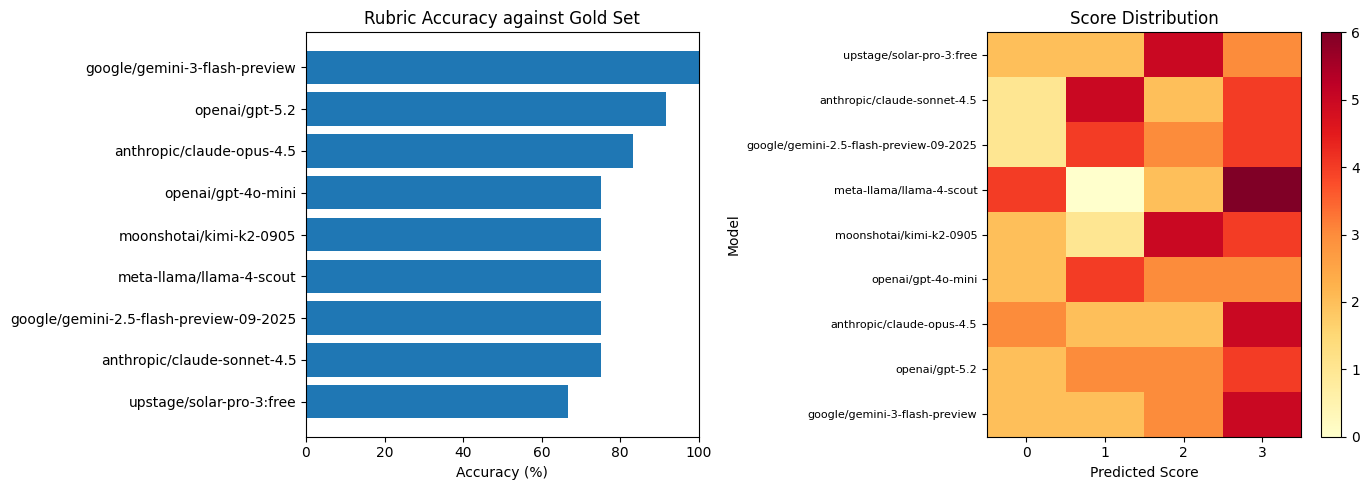

In [21]:
# Visualize results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sort model_accuracy by accuracy in descending order
model_accuracy_sorted = model_accuracy.sort_values('accuracy', ascending=True)

# Accuracy bar chart
axes[0].barh(model_accuracy_sorted['model'], model_accuracy_sorted['accuracy'])
axes[0].set_xlabel('Accuracy (%)')
axes[0].set_title('Rubric Accuracy against Gold Set')
axes[0].set_xlim(0, 100)

# Score distribution heatmap - reorder by accuracy
score_dist_plot = df.groupby(['model', 'predicted_score']).size().unstack(fill_value=0)
score_dist_plot = score_dist_plot.reindex(model_accuracy_sorted['model'])
im = axes[1].imshow(score_dist_plot.values, aspect='auto', cmap='YlOrRd')
axes[1].set_xticks(range(len(score_dist_plot.columns)))
axes[1].set_xticklabels(score_dist_plot.columns)
axes[1].set_yticks(range(len(score_dist_plot.index)))
axes[1].set_yticklabels(score_dist_plot.index, fontsize=8)
axes[1].set_xlabel('Predicted Score')
axes[1].set_ylabel('Model')
axes[1].set_title('Score Distribution')
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

In [22]:
# Save results to JSON
output_file = 'structured_grader_evaluation_results.json'
with open(output_file, 'w') as f:
    json.dump(results, f, indent=2)
print(f"\nResults saved to {output_file}")

# Save summary to CSV
summary_file = 'structured_grader_evaluation_summary.csv'
df.to_csv(summary_file, index=False)
print(f"Summary saved to {summary_file}")


Results saved to structured_grader_evaluation_results.json
Summary saved to structured_grader_evaluation_summary.csv


## Analysis of Disagreements

Examine cases where models disagreed with expected scores

In [23]:
# Find disagreements
disagreements = df[df['match'] == False].copy()

if len(disagreements) > 0:
    print(f"\nFound {len(disagreements)} disagreements:")
    print("="*60)
    
    for idx, row in disagreements.iterrows():
        print(f"\nTest Case {row['test_case_id']} - Model: {row['model']}")
        print(f"  Question: {row['question']}")
        print(f"  AI Response: {row['ai_response']}")
        print(f"  Ground Truth: {row['ground_truth']}")
        print(f"  Expected Score: {row['expected_score']}")
        print(f"  Predicted Score: {row['predicted_score']}")
        print(f"  Reasoning: {row['reasoning']}")
else:
    print("\nNo disagreements found - all models matched expected scores!")


Found 22 disagreements:

Test Case 3 - Model: meta-llama/llama-4-scout
  Question: For all patients who are older than 55 years old, what is the percentage of female who has abnormal prothrombin time (PT)?
  AI Response: For patients older than 55 years old who are female (SEX = 'F'), there are 8,744 total females and 153 of them have an abnormal prothrombin time (PT > 13.5).

To calculate the percentage of females with abnormal PT: (153 / 8744) * 100 = 1.75%

So, approximately 1.75% of females older than 55 years have an abnormal prothrombin time (PT).
  Ground Truth: [(1.2037369744879627,)]
  Expected Score: 1
  Predicted Score: 0
  Reasoning: The AI response provides a detailed calculation and states that approximately 1.75% of females older than 55 years have an abnormal prothrombin time (PT). The ground truth provided is a specific number: 1.2037369744879627. The AI response does not exactly match the ground truth value but instead provides a calculated percentage. However, to as